In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

# Dataset Overview

In [2]:
train = pd.read_csv("data/train.csv")
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [4]:
train.nunique()

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

### Columns and Descriptions

| Column            | Description                                                 |
|-------------------|-------------------------------------------------------------|
| **PassengerId**   | id in the form of gggg_pp, gggg indicating a group and pp the number in the group |
| **HomePlanet**    | origin of passengers (Earth, Europa, Mars). only 3 values.  |
| **CryoSleep**     | boolean: were they in cryosleep?                            |
| **Cabin**         | cabin info (split into deck, num, and side).                |
| **Destination**   | intended destination (e.g., TRAPPIST-1e).                   |
| **Age**           | passenger's age.                                            |
| **VIP**           | boolean: paid for special services.                         |
| **RoomService** → **VRDeck** | amount spent on various facilities.              |
| **Name**          | first and last name (may be irrelevant... unless...?).      |
| **Transported**   | target: were they transported to an alternate dimension?    |

### Future Hypotheses to explore
- Does being in the same group indicate a higher chance of all of them being transported or is it random?
- Was it proportionally favoured towards a certain passenger group with specific origin?
- Can people in cryosleep (variable = 1) still spend on various facilities?
- Does cabin location affect the chance of being transported?
- If the ship collided midway, does destination really affect if they were transported? If it does, does it vary proportionally across different destinations?
- Did VIPs have a higher chance of not being transported?

# Exploratory Data Analysis
### Transported Column Analysis

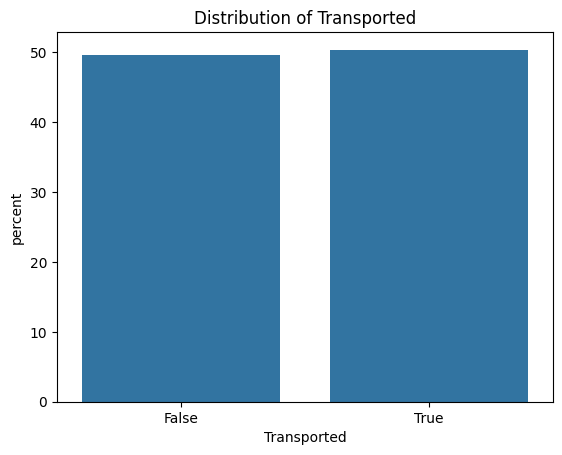

In [22]:
# Visualising distribution of Transported column
sns.countplot(train, x="Transported", stat="percent")
plt.title('Distribution of Transported')
plt.show()

### Checking Missing Values

In [5]:
train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

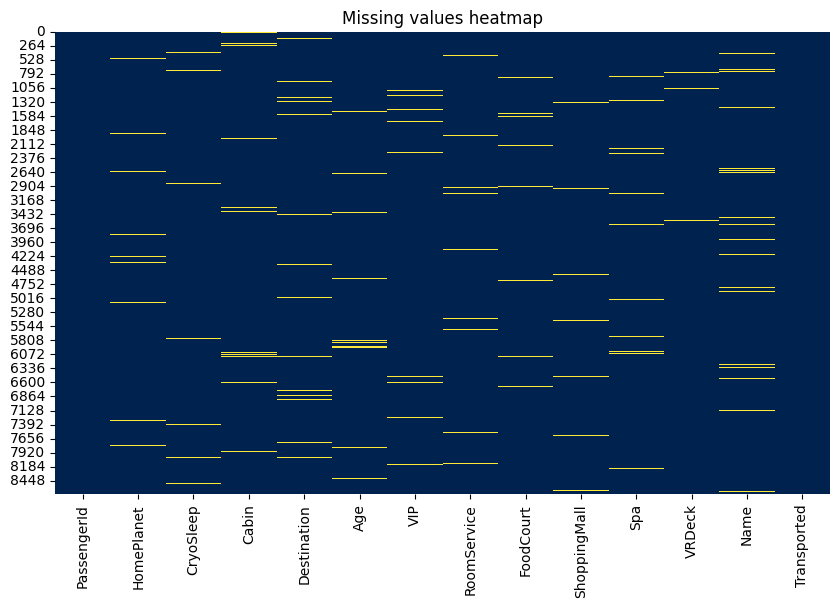

In [ ]:
# Creating a heatmap to visualise missing values
plt.figure(figsize=(10, 6))
sns.heatmap(train.isnull(), cbar=False, cmap='cividis')
plt.title("Missing values heatmap")
plt.show()

In [7]:
# Calculating the proportion of people being transported if they have missing values in each column
for col in train.columns:
    if train[col].isnull().sum() > 0:
        transport_rate = train[train[col].isna()]['Transported'].mean()
        print(f'Chance of transportation given {col} is missing: {transport_rate:.3f}')

Chance of transportation given HomePlanet is missing: 0.512
Chance of transportation given CryoSleep is missing: 0.488
Chance of transportation given Cabin is missing: 0.503
Chance of transportation given Destination is missing: 0.505
Chance of transportation given Age is missing: 0.503
Chance of transportation given VIP is missing: 0.512
Chance of transportation given RoomService is missing: 0.459
Chance of transportation given FoodCourt is missing: 0.541
Chance of transportation given ShoppingMall is missing: 0.548
Chance of transportation given Spa is missing: 0.497
Chance of transportation given VRDeck is missing: 0.521
Chance of transportation given Name is missing: 0.505


### Missing data analysis

For all relevant columns, it is almost a probability of 0.5. It means that for any passengers with missing values, it is still almost 50% chance the passenger is transported. This implies that missing values do not correlate with the target being missing.

However, there is some intuition behind certain columns having missing values. If a person's CryoSleep is missing, it could imply that they were not in cryosleep, while people who have empty values in VIP could mean that they were not VIPs. For the columns RoomService to VRDeck, it could mean that they spent 0 on those services, but whether or not these are true remain to be tested.

In [24]:
warnings.filterwarnings('ignore', category=FutureWarning) # ignoring futurewarnings

# Testing if CryoSleep = False affects transportation rate
cryosleep_transport_rate_before = train[train['CryoSleep'].notna()].groupby('CryoSleep')['Transported'].mean()
print('Before:\n', cryosleep_transport_rate_before)

traincryo = train.copy(deep=True)
traincryo['CryoSleep'].fillna(False, inplace=True)
cryosleep_transport_rate_after = traincryo.groupby('CryoSleep')['Transported'].mean()
print('After:\n', cryosleep_transport_rate_after)

Before:
 CryoSleep
False    0.328921
True     0.817583
Name: Transported, dtype: float64
After:
 CryoSleep
False    0.335042
True     0.817583
Name: Transported, dtype: float64


The transportation rate for Cryosleep = False increased a bit from 0.3289 to 0.3350, while the rate for Cryosleep = True remained constant. This implies that the distribution of the passengers with missing CryoSleep values largely aligns with the original distribution of passengers.

In [67]:
# Testing if missing spending variables (RoomService to VRDeck) can be changed to 0

# Define a function
def missing_spending(data, col):
    before = data[(data[col].notna()) & (data[col] == 0)].groupby(col)['Transported'].mean()
    before = round(before[0], 3)
    
    newdata = data.copy(deep=True)
    newdata[col].fillna(0, inplace=True)
    after = newdata[newdata[col] == 0].groupby(col)["Transported"].mean()
    after = round(after[0], 3)
    
    print(f"{col}:\nBefore: {before}, After: {after}")
    if abs(before-after) < 0.01:
        print(f'No significant difference after changing missing values in column {col} to 0')
    else:
        print(f'Significant difference, should not change missing values in column {col} to 0')

important_cols = train.columns[[i for i in range(7, 12)]]
for col in important_cols:
    missing_spending(train, col)

RoomService:
Before: 0.633, After: 0.628
No significant difference after changing missing values in column RoomService to 0
FoodCourt:
Before: 0.591, After: 0.589
No significant difference after changing missing values in column FoodCourt to 0
ShoppingMall:
Before: 0.599, After: 0.597
No significant difference after changing missing values in column ShoppingMall to 0
Spa:
Before: 0.639, After: 0.634
No significant difference after changing missing values in column Spa to 0
VRDeck:
Before: 0.628, After: 0.624
No significant difference after changing missing values in column VRDeck to 0


Since changing the missing values in all the spending columns to 0 does not significantly affect the transportation rate, it is same to assume that we can impute all missing values as 0 for these 5 columns.

### Feature Exploration
#### Numerical Features

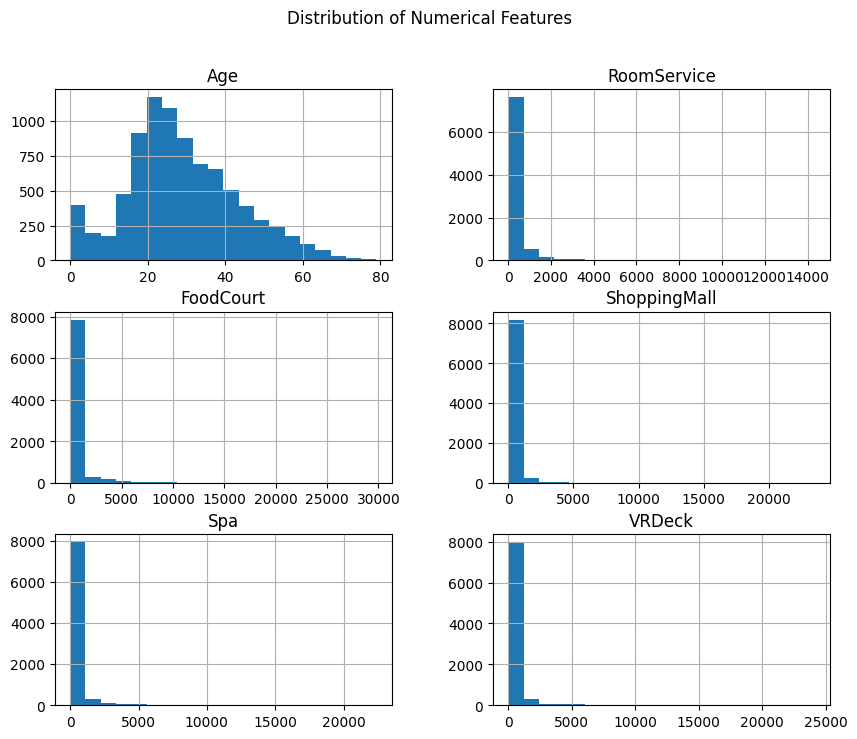

In [77]:
numerical_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
train[numerical_features].hist(figsize=(10, 8), bins=20)
plt.suptitle('Distribution of Numerical Features')
plt.show()

#### Categorical Features